## 22070126001
## Aaradhya Badal

## Imports

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set device

torch.manual_seed(42) # Set manual seed for reproducibility
np.random.seed(42)
print(device)

cuda


## Initiallization

In [1]:
# Hyperparameters
image_size = 64
batch_size = 128
latent_dim = 100
lr_D = 0.0001  # Lowered learning rate for Discriminator
lr_G = 0.0002  # Generator learning rate stays the same
num_epochs = 10
beta1 = 0.5
beta2 = 0.999


transform = transforms.Compose([ # Load Dataset
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


dataset = datasets.ImageFolder(root=r"/kaggle/input/celeba-dataset/img_align_celeba", transform=transform)


In [18]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True , num_workers=4)

In [19]:
# Generator

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


generator = Generator(latent_dim).to(device) # Initialize Generator

In [20]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Added dropout

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Added dropout

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


discriminator = Discriminator().to(device) # Initialize Discriminator

In [21]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(beta1, beta2))

In [22]:
import random

fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device) # Fixed noise for tracking generator progress


for epoch in range(num_epochs): # Training
    for i, data in enumerate(dataloader):
        real_images = data[0].to(device)
        batch_size = real_images.size(0)

        # Create Smoothed Labels
        real_labels = torch.full((batch_size, 1), random.uniform(0.8, 1.0), device=device)
        fake_labels = torch.full((batch_size, 1), random.uniform(0.0, 0.2), device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        output_real = discriminator(real_images).view(-1, 1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach()).view(-1, 1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)  # Gradient Clipping
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_labels_gen = torch.full((batch_size, 1), random.uniform(0.9, 1.0), device=device)
        output_fake_G = discriminator(fake_images).view(-1, 1)
        loss_G = criterion(output_fake_G, fake_labels_gen)
        loss_G.backward()
        optimizer_G.step()

        if i % 100 == 0: # Print training status
            print(f"Epoch [{epoch + 1}/{num_epochs}] Batch {i}/{len(dataloader)} Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

    # Save generated images at each epoch
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        grid = vutils.make_grid(fake_images, normalize=True)
        vutils.save_image(grid, f"generated_epoch_{epoch}.png")

print("Training Complete!")

Epoch [1/10] Batch 0/1583 Loss D: 1.4300562143325806, Loss G: 1.1530256271362305
Epoch [1/10] Batch 100/1583 Loss D: 1.208134412765503, Loss G: 1.4748148918151855
Epoch [1/10] Batch 200/1583 Loss D: 1.0425913333892822, Loss G: 1.949005365371704
Epoch [1/10] Batch 300/1583 Loss D: 1.1478307247161865, Loss G: 1.5110325813293457
Epoch [1/10] Batch 400/1583 Loss D: 1.016381025314331, Loss G: 1.6841285228729248
Epoch [1/10] Batch 500/1583 Loss D: 1.2667076587677002, Loss G: 1.6304292678833008
Epoch [1/10] Batch 600/1583 Loss D: 1.3685249090194702, Loss G: 1.253191351890564
Epoch [1/10] Batch 700/1583 Loss D: 0.9131935834884644, Loss G: 2.652254581451416
Epoch [1/10] Batch 800/1583 Loss D: 1.2526644468307495, Loss G: 1.0519620180130005
Epoch [1/10] Batch 900/1583 Loss D: 1.283431053161621, Loss G: 1.3380422592163086
Epoch [1/10] Batch 1000/1583 Loss D: 1.3617370128631592, Loss G: 0.9726395606994629
Epoch [1/10] Batch 1100/1583 Loss D: 1.0437158346176147, Loss G: 1.9754011631011963
Epoch [1/1

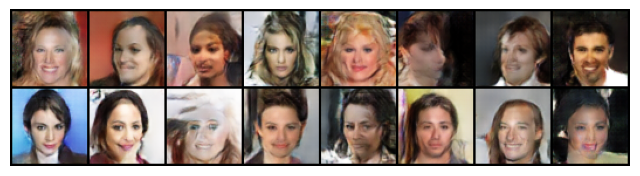

In [23]:
import matplotlib.pyplot as plt
from PIL import Image

#displays an image
epoch_num = 9  
image_path = f"generated_epoch_{epoch_num}.png"
img = Image.open(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

In [26]:
torch.save(generator.state_dict(), "/kaggle/working/generator.pth")
torch.save(discriminator.state_dict(), "/kaggle/working/discriminator.pth")